<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://www.univ-tlse3.fr/" ><img src="http://www.univ-tlse3.fr/medias/photo/ut3pres_logoq_1372757033342.jpg?ID_FICHE=49702" style="float:right; max-width: 250px; display: inline" alt="INSA"/></a> 
</center>

# Biais et Discrimination en Apprentissage Statistique
## Controverse sur le score de récidive aux USA:  equivant *vs.* Propublica 

### Résumé

## 1 Introduction

### 1.1 Données COMPAS
La méthodologie de Propublica pour le recueil des données est décrite dans un article de [Larson et al. (2016)](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm/). Le jeu de données étudié est  disponible sur leur [site officiel](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm/).
### 1.2 Objectifs
 Une version simpifiée de l'analyse de Propublica est décrite ci-dessous afin de se focaliser sur les questions de biais et donc de discrimination potentielle. Le processus de sélection des données est celui de Propublica avant de procéder à une decription élémentaire pour ensuite étudier et caractériser différents types de biais: 
- estimation par intervalle de confiance de l'effet disproportionné sur les données réelles, 
- même estimation de l'effet pour le score de récidive (COMPAS) *High vs. low* calculé par *equivant*,
- puis sur le score prédit par une simple régression logistique,
- comparaison des erreurs de prévision, COMPAS et régression logistique, selon l'origine ethnique, 
- caractérisation de l'asymétrie des matrices de confusion à l'aide d'un intervalle de confiance.

C'est ce dernier point qui est à l'origine de la controverse entre *equivant* (Northpoint) et Propublica.

## 2 Prise en charge des données
### 2.1 Lecture



In [2]:
# Quelques librairies utiles
library(dplyr)
library(ggplot2)
library(grid)
library(gridExtra)
library(FactoMineR)
# Lecture des données
raw_data <- read.csv("./compas-scores-two-years.csv")
dim(raw_data)

[1] 7214   53

In [3]:
summary(raw_data)

       id                       name              first            last     
 Min.   :    1   anthony smith    :   3   michael    : 149   williams:  83  
 1st Qu.: 2735   angel santiago   :   2   christopher: 109   johnson :  76  
 Median : 5510   anthony gonzalez :   2   james      :  84   brown   :  68  
 Mean   : 5501   anthony louis    :   2   anthony    :  83   smith   :  65  
 3rd Qu.: 8246   brandon whitfield:   2   robert     :  76   jones   :  57  
 Max.   :11001   carlos vasquez   :   2   john       :  74   davis   :  46  
                 (Other)          :7201   (Other)    :6639   (Other) :6819  
 compas_screening_date     sex               dob            age       
 2013-02-20:  32       Female:1395   1987-02-04:   5   Min.   :18.00  
 2013-03-20:  32       Male  :5819   1987-12-21:   5   1st Qu.:25.00  
 2013-02-07:  31                     1989-04-27:   5   Median :31.00  
 2013-04-20:  30                     1989-08-31:   5   Mean   :34.82  
 2013-01-03:  29             

### 2.2 Préparation des données

Elimination de certaines lignes en suivant le processus de Propublica. 
* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [4]:
df <- dplyr::select(raw_data, age, c_charge_degree, race, age_cat, score_text, sex, priors_count, 
        days_b_screening_arrest, decile_score, is_recid, two_year_recid, c_jail_in, c_jail_out,v_decile_score) %>% 
        filter(days_b_screening_arrest <= 30) %>%
        filter(days_b_screening_arrest >= -30) %>%
        filter(is_recid != -1) %>%
        filter(c_charge_degree != "O") %>%
        filter(score_text != 'N/A')
dim(df)

[1] 6172   14

In [5]:
# renommer la variable "race"
colnames(df)[3]='origEthn'
summary(df)

      age        c_charge_degree             origEthn               age_cat    
 Min.   :18.00   F:3970          African-American:3175   25 - 45        :3532  
 1st Qu.:25.00   M:2202          Asian           :  31   Greater than 45:1293  
 Median :31.00                   Caucasian       :2103   Less than 25   :1347  
 Mean   :34.53                   Hispanic        : 509                         
 3rd Qu.:42.00                   Native American :  11                         
 Max.   :96.00                   Other           : 343                         
                                                                               
  score_text       sex        priors_count    days_b_screening_arrest
 High  :1144   Female:1175   Min.   : 0.000   Min.   :-30.00         
 Low   :3421   Male  :4997   1st Qu.: 0.000   1st Qu.: -1.00         
 Medium:1607                 Median : 1.000   Median : -1.00         
                             Mean   : 3.246   Mean   : -1.74         
          

In [6]:
str(df)

'data.frame':	6172 obs. of  14 variables:
 $ age                    : int  69 34 24 44 41 43 39 27 23 37 ...
 $ c_charge_degree        : Factor w/ 2 levels "F","M": 1 1 1 2 1 1 2 1 2 2 ...
 $ origEthn               : Factor w/ 6 levels "African-American",..: 6 1 1 6 3 6 3 3 1 3 ...
 $ age_cat                : Factor w/ 3 levels "25 - 45","Greater than 45",..: 2 1 3 1 1 1 1 1 3 1 ...
 $ score_text             : Factor w/ 3 levels "High","Low","Medium": 2 2 2 2 3 2 2 2 3 2 ...
 $ sex                    : Factor w/ 2 levels "Female","Male": 2 2 2 2 2 2 1 2 2 1 ...
 $ priors_count           : int  0 0 4 0 14 3 0 0 3 0 ...
 $ days_b_screening_arrest: int  -1 -1 -1 0 -1 -1 -1 -1 0 0 ...
 $ decile_score           : int  1 3 4 1 6 4 1 4 6 1 ...
 $ is_recid               : int  0 1 1 0 1 0 0 0 1 0 ...
 $ two_year_recid         : int  0 1 1 0 1 0 0 0 1 0 ...
 $ c_jail_in              : Factor w/ 6908 levels "","2013-01-01 01:31:55",..: 3032 454 1838 4434 5450 3273 5707 4391 3735 4 ...
 $ c_jail_

## 3 Exploration statistique

### 3.1 Description Univariée

Représentation des distributions des différentes variables.

#### Variables quantitatives

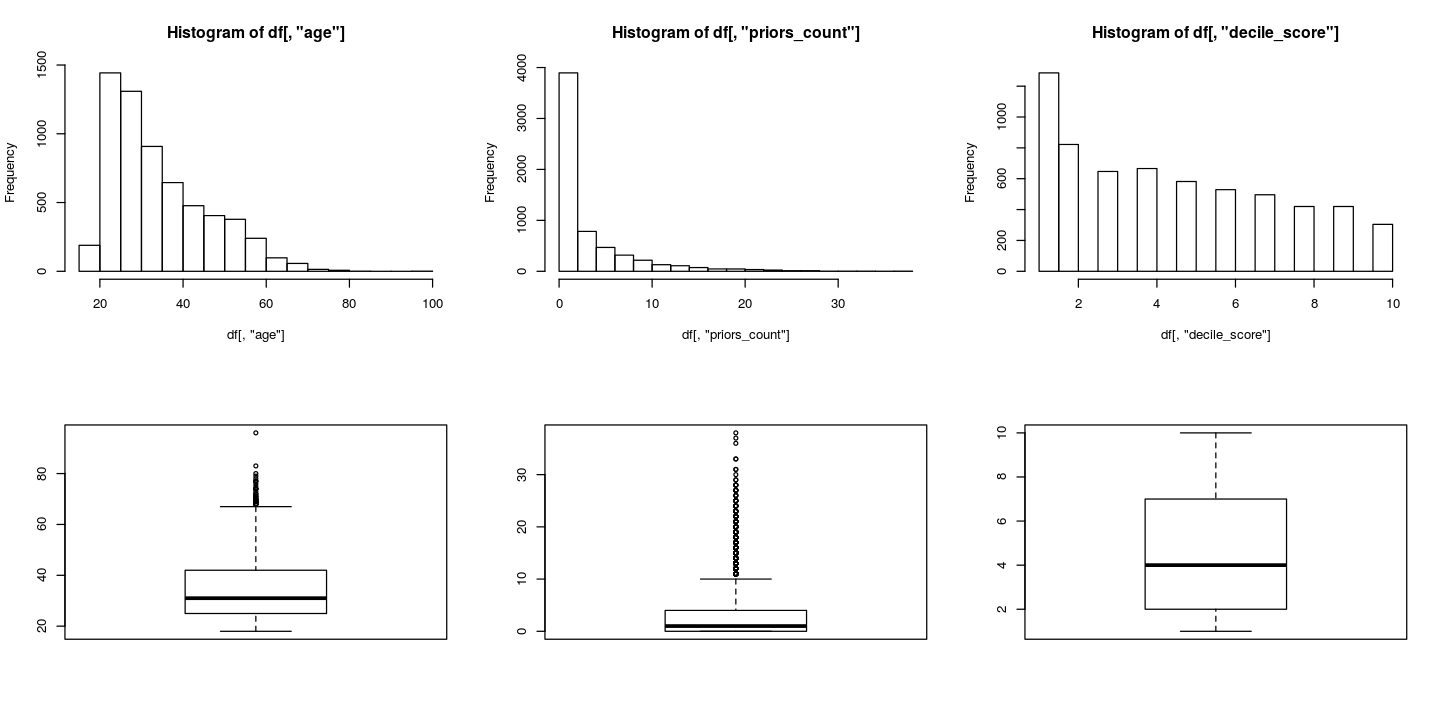

In [7]:
par(mfrow=c(2,3))
options(repr.plot.width=12, repr.plot.height=6)
hist(df[,'age']); hist(df[,'priors_count']); hist(df[,'decile_score'])
boxplot(df[,'age']); boxplot(df[,'priors_count']); boxplot(df[,'decile_score'])

Des distributions ne sont pas symmétriques mais, pour rester cohérent avec l'analyse de Propublica aucune transformation n'est appliquée sur ces variables.
#### Variables qualitatives

In [8]:
df$two_year_recid=as.factor(df$two_year_recid)
df$is_recid=as.factor(df$is_recid)
two_year_recid=ggplot(data=df, aes(x=two_year_recid))+geom_bar(width=0.2)
is_recid=ggplot(data=df, aes(x=is_recid))+geom_bar(width=0.2)
origEthn=ggplot(data=df, aes(x=origEthn))+geom_bar(width=0.2)
age_cat=ggplot(data=df, aes(x=age_cat))+geom_bar(width=0.2)
sex=ggplot(data=df, aes(x=sex))+geom_bar(width=0.2)
c_charge_degree=ggplot(data=df, aes(x=c_charge_degree))+geom_bar(width=0.2)
score_text=ggplot(data=df, aes(x=score_text))+geom_bar(width=0.2)

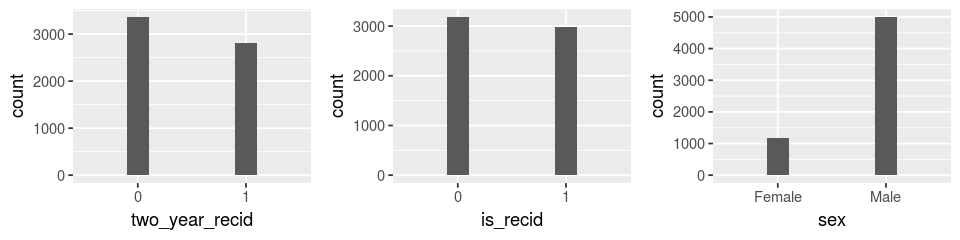

In [9]:
options(repr.plot.width=8,repr.plot.height=2)
grid.arrange(two_year_recid,is_recid,sex,nrow=1)

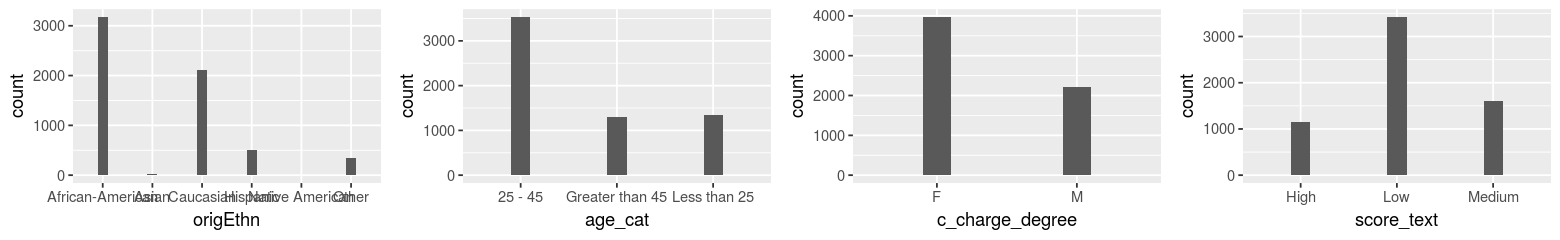

In [10]:
options(repr.plot.width=13,repr.plot.height=2)
grid.arrange(origEthn,age_cat,c_charge_degree,score_text,nrow=1)

La répartition des origines ethniques sont déséquilibrées; seules deux classes sont ensuite considées
- `African-American`
- `Caucasian`

en laissant de côté les origines hispaniques, asiatiques, amérindiennes et autres.


In [11]:
df_f=droplevels(df[df$origEthn =="Caucasian" | df$origEthn =="African-American",])
summary(df_f)

      age        c_charge_degree             origEthn               age_cat    
 Min.   :18.00   F:3440          African-American:3175   25 - 45        :3026  
 1st Qu.:25.00   M:1838          Caucasian       :2103   Greater than 45:1096  
 Median :31.00                                           Less than 25   :1156  
 Mean   :34.45                                                                 
 3rd Qu.:42.00                                                                 
 Max.   :80.00                                                                 
                                                                               
  score_text       sex        priors_count    days_b_screening_arrest
 High  :1068   Female:1031   Min.   : 0.000   Min.   :-30.00         
 Low   :2753   Male  :4247   1st Qu.: 0.000   1st Qu.: -1.00         
 Medium:1457                 Median : 2.000   Median : -1.00         
                             Mean   : 3.462   Mean   : -1.73         
          

### 3.2 Description bivariée
#### Mosaicplots
Les variables `two_year_recid`  et `is_recid` sont redondantes; la première n'est plus considérée.

In [12]:
table(df_f$is_recid,df_f$two_year_recid)

   
       0    1
  0 2631    0
  1  164 2483

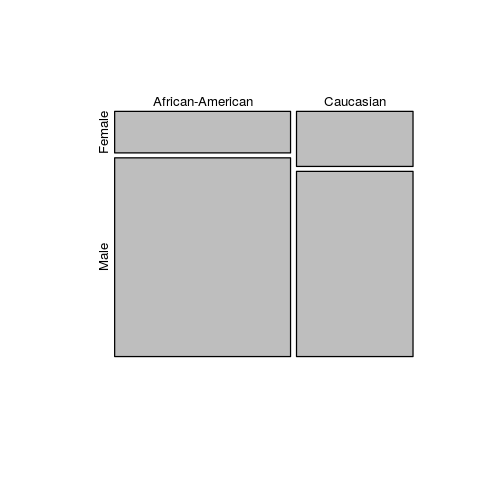

In [13]:
options(repr.plot.width=4,repr.plot.height=4)
mosaicplot(table(df_f$origEthn,df_f$sex),main="")

Les femmes sont bien moins nombreuses et aussi proportionnellement moins présentes parmis les afro-américaines.

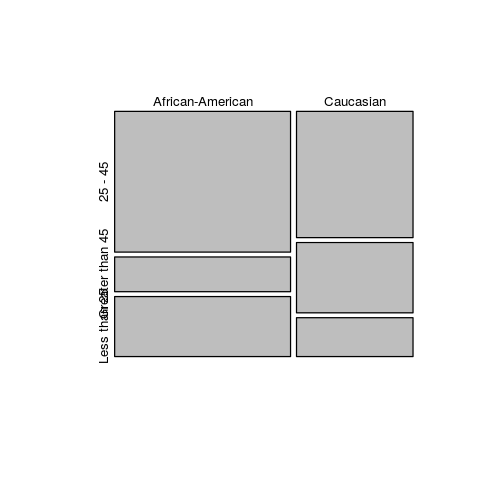

In [14]:
mosaicplot(table(df_f$origEthn,df_f$age_cat),main="")

Il y'a  proportionnellement plus de jeunes parmi les afro-américains.

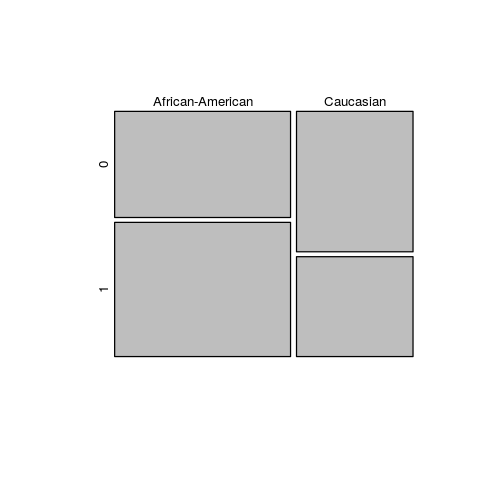

In [15]:
mosaicplot(table(df_f$origEthn,df_f$is_recid),main="")

Et aussi proportionnellement plus de récidivistes. C'est un biais social connu et une information importante à retenir pour la suite.

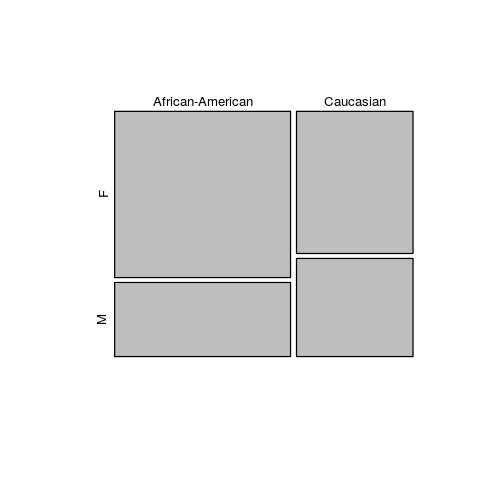

In [16]:
mosaicplot(table(df_f$origEthn,df_f$c_charge_degree),main="")

Même interprétation que précédemment cette fois sur le degré de l'infraction commise qui peut être élevé (F) ou faible(M).

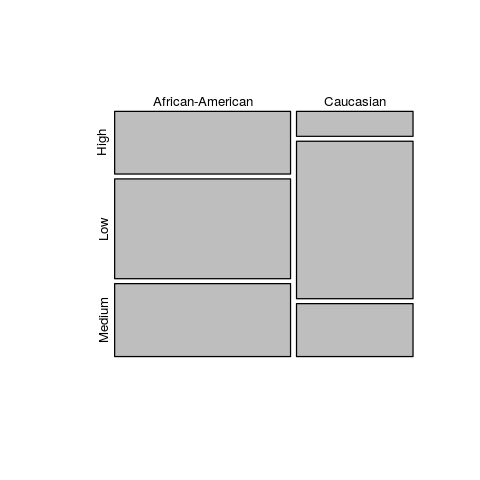

In [17]:
options(repr.plot.width=4,repr.plot.height=4)
mosaicplot(table(df_f$origEthn,df_f$score_text),main='')

De façon analogue, les afro-américains sont proportionnellement plus associés à un score élevé (High) de récidive.


### 3.3 Description Multivariée

Une [Analyse Factorielle des Corresponsances Multiples](http://wikistat.fr/pdf/st-m-explo-afcm.pdf) est adaptée à la représentation des modalités de variables qualitatives.

In [18]:
df_quali=subset(df_f,select=c('is_recid','sex','origEthn','age_cat','c_charge_degree','score_text'))
afcm=MCA(df_quali,graph=FALSE)

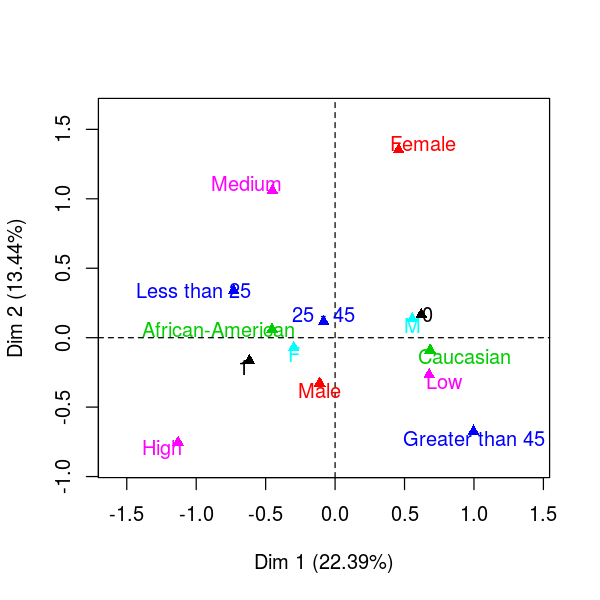

In [19]:
options(repr.plot.width=5, repr.plot.height=5)
plot.MCA(afcm,invisible='ind',habillage="quali", title="")

Ce graphique représente assez simplement les correspondances entre les modalités et donc globalement les liens entre les variables. La non récidive (à droite) concerne particulièrement les personnes plus agées, de sexe plutôt féminin, d'origine caucasienne avec un faible score COMPAS. Attention, cette analyse élémentaire ne prend pas en compte d'éventuelles interaction de niveau plus important que 2 entre les variables.

### 3.4 Simplification des données
Dans tous ce qui suit, la variable `score_text` est recodée en deux modalités:
- 1 = `low` (la classe favorable),
- 0 = `high` et `medium`;

de même que la variable `two_year_recid`.

*NB* Les codes des classes 0 et 1 sont échangées par rapport aux notations de Propublica dans un souci d'uniformisation par rapport aux méthodes implémentées par la suite: `1` code la situation la plus "favorable" c'est-à-dire un faible score de récidive d'une part, une absence de récidive d'autre part.

In [20]:
score_bin=as.factor(ifelse(df_f$score_text=='Low',1,0))
two_year_recid_bin=as.factor(ifelse(df_f$two_year_recid=='1',0,1))
df_t=data.frame(df_f,score_bin,two_year_recid_bin)
summary(df_t)

      age        c_charge_degree             origEthn               age_cat    
 Min.   :18.00   F:3440          African-American:3175   25 - 45        :3026  
 1st Qu.:25.00   M:1838          Caucasian       :2103   Greater than 45:1096  
 Median :31.00                                           Less than 25   :1156  
 Mean   :34.45                                                                 
 3rd Qu.:42.00                                                                 
 Max.   :80.00                                                                 
                                                                               
  score_text       sex        priors_count    days_b_screening_arrest
 High  :1068   Female:1031   Min.   : 0.000   Min.   :-30.00         
 Low   :2753   Male  :4247   1st Qu.: 0.000   1st Qu.: -1.00         
 Medium:1457                 Median : 2.000   Median : -1.00         
                             Mean   : 3.462   Mean   : -1.73         
          

In [93]:
table(df_f$two_year_recid,df_f$is_recid)

   
       0    1
  0 2631  164
  1    0 2483

## 4 Biais et discriminations
Différents critères de biais ou discrimination sont évalués; trois niveaux sont successivement considérés.

1. L'effet disproportionné (*disparate impact*) est couramment utilisés pour détecter aux USA une discrimination indirecte ou implicite ou envers un groupe pour l'accès à l'emploi ou un logement. Il est estimé par intervalle de confiance (Besse et al. 2008) en fonction des répartitions par origine des
    - récidives afin de mettre en évidence des biais déjà présents dans les données, 
    - prévisions de récidive issues du score Compas afin dévaluer si la prévision répercute ou renforce ce biais.
2. La comparaison des erreurs de prévision conditionnellement à l'origine etnique. 
3. Enfin, selon la démarche de Propublica, c'est l'assymétrie des matrices de confusion selon l'origine ethnique qui est étudiée.

### 4.1 *Disparate Impact* ou effet disproportionné

Deux niveaux de mesures de discrimination sont considérées. Le premier: *discrimination assessment* ou DA est calculé sur les données d'apprentissage afin d'évaluer le biais discriminatoire déjà présent dans les données. Le deuxième mesure l'impact d'un modèle ou algorithme sur la discrimination: *discrimination impact assessment* ou DIA. 

Les mesures de discrimination indirecte ou de groupe sont basées sur un critère d'effet disproportionné ou *disparate impact* (*DI*). Ce critère est défini par le rapport de deux probabilités. 

*Notations*: 

- $Y$ est la variable cible ou à expliquer, ici la récidive, $Y=1$ pas de récidive *vs* $Y=0$; 
- $\hat{Y}$ le score de récidive élevé ou faible ou prévision de la récidive, $\hat{Y}=0$: prévision d'une récidive;
- $S$ est la variable sensible qui désigne le groupe en principe protégé par la loi contre une possible discrimination. Il s'agit ici de l'origine ethnique réduite à 2 modalités: caucasien ($S=1$) ou afro-américain ($S=0$). 

$$DI=\frac{P(Y=1|S=0)}{P(Y=1|S=1)}.$$

Cette quantité est estimée à partir des valeurs de la table de contingence croisant les variables $Y$ et $S$.

*Fonction* `disparate`

Une fonction R estime cette quantité et fournit de plus une estimation par intervalle de confiance (Besse et al. 2018) du *DI*. Cette  fonction a trois arguments:   
- une matrice $X$ de valeurs binaires $(0,1)$ dont la dernière colonne contient la décision $Y$ ou cible à analyser;
- l'indice $S$ de la variable de $X$ considérée comme sensible; 
- le risque de l'intervalle de confiance, par défaut 5%.

Elle renvoie les trois estimations $DI$ et $IC_g$, $IC_d$ bornes de l'intervalle de confiance.

In [21]:
# Construction du data frame
s= as.integer(df_t$origEthn)-1
Y=2-as.integer(df_t$two_year_recid)
Ycompas=1-as.integer(df_t$decile_score>4)
coded_data=data.frame("OrigEthn"=s,Ycompas,Y)
cbind(coded_data,df_t[,c("origEthn","decile_score","two_year_recid")])[5:15,]

,OrigEthn,Ycompas,Y,origEthn,decile_score,two_year_recid
8,1,1,1,Caucasian,4,0
9,0,0,0,African-American,6,1
10,1,1,1,Caucasian,1,0
11,0,1,1,African-American,4,0
12,1,1,0,Caucasian,1,1
13,0,1,0,African-American,3,1
15,0,0,1,African-American,10,0
16,1,0,0,Caucasian,5,1
17,1,1,0,Caucasian,3,1
18,0,0,0,African-American,6,1


In [59]:
table(coded_data$Y,coded_data$OrigEthn)

   
       0    1
  0 1661  822
  1 1514 1281

#### $DI$ estimé sur la base d'apprentissage 
Estimation ponctuelle du $DI$ pour déterminer le biais sociale de la variable observée $Y$ de récidive.

In [61]:
DI=function(table){round((table[2,1]/(table[1,1]+table[2,1]))/(table[2,2]/(table[1,2]+table[2,2])),2)}
DI(table(coded_data$Y,coded_data$OrigEthn))

[1] 0.78

Estimation par intervalle de confiance.

In [29]:
source('disparate.R')
round(disparate(coded_data,1),2)

[1] 0.74 0.78 0.82

Il y a proportionnellement plus de récidive pour une origine afro-américaine mais sans que celle-ci soit disproportionnée car $0.8 \in DI$

#### $DI$ sur la base du score COMPAS
Estimation ponctuelle.

In [62]:
DI(table(coded_data$Ycompas,coded_data$OrigEthn))

[1] 0.63

Estimation par intervalle de confiance.

In [30]:
round(disparate(coded_data[,-3],1),2)

[1] 0.60 0.63 0.67

Le score Compas renforce significativement le caractère discriminatoire car les intervalles sont disjoints. C'est contradictoire sur cet exemple avec les affirmation d'*equivant* qui affirme que les score se distribuent de façon identique selon l'origine ethnique.

### 4.2 Taux d'erreur selon l'origine
L'estimation du taux d'erreur induit par le score Compas peut être calculée avec l'ensemble des données car le modèle sous-jacent a été estimé sur d'autres données.

In [64]:
tauxErr=function(table){round((table[1,2]+table[2,1])/sum(table)*100,1)}

In [65]:
tauxErr(table(df_t$decile_score>4,df_t$two_year_recid==1))

[1] 34.2

On trouve comme attendu un taux d'erreur important de 34% qui est ventilé selon l'origine:

In [28]:
apply(table(df_t$decile_score>4,df_t$two_year_recid==1,df_t$origEthn),3,tauxErr)

African-American        Caucasian 
            35.1             32.8

*Question*: ces taux d'erreur sont-ils significativement différents? Estimation d'intervalles de confiance par delta method? par bootstrap ? par validation croisée généralisée?

En principe *equivant* affirme que ces taux sont similaires pour qu'il n'y ait pas discrimination; cela semble peu probant sur ces données.

### 4.3 Assymétrie des matrices de confusion
Deux autres méthodes s'intéresse aux dissymétries des matrices de confusion qui peuvent apparaître même si globalement les taux d'erreur sont similaires. Il s'agit de comparer les taux de faux positifs et de faux négatifs selon l'origine. Cette approche est détaillée par [Besse et al. 2018](https://arxiv.org/pdf/1807.06362.pdf) par l'estimation d'un critère noté OAE (*Overall Accuracy Equality*).

OAE $= \frac{P(\hat{Y}=0|Y=1,S=1)}{P(\hat{Y}=0|Y=1,S=0)}=\frac{P(\hat{Y}=0,Y=1,S=1)}{ P(Y=1,S=1)}\times \frac{P(Y=1,S=0)}{P(\hat{Y}=0,Y=1,S=0)}$

#### Estimation ponctuelle de OAE

In [82]:
table(df_t$decile_score>4,df_t$two_year_recid==1,df_t$origEthn)

, ,  = African-American

       
        FALSE TRUE
  FALSE   873  473
  TRUE    641 1188

, ,  = Caucasian

       
        FALSE TRUE
  FALSE   999  408
  TRUE    282  414


Comparaison des taux de faux positifs (FPR)

In [91]:
641/(641+873); 282/(282+999);

[1] 0.4233818

[1] 0.2201405

In [ ]:
Comparaison des taux de vrais positifs (TPR)

In [92]:
1188/(1188+473);414/(414+408)

[1] 0.7152318

[1] 0.5036496

In [32]:
n=nrow(coded_data)
p011=(sum((1-coded_data$Ycomp)*coded_data$Y*coded_data$OrigEthn))/n # P(\hat{Y}=0,Y=1,S=1)
p010=(sum((1-coded_data$Ycomp)*coded_data$Y*(1-coded_data$OrigEthn)))/n # P(\hat{Y}=0,Y=1,S=0)
r11=(sum(coded_data$Y*coded_data$OrigEthn))/n # P(Y=1,S=1)
r10=(sum(coded_data$Y*(1-coded_data$OrigEthn)))/n # P(Y=1,S=0)

In [33]:
p011;p010;r11;r10

[1] 0.05342933

[1] 0.1214475

[1] 0.2427056

[1] 0.2868511

In [34]:
(p011/r11)/(p010/r10)
1/((p011/r11)/(p010/r10))

[1] 0.5199575

[1] 1.923234

#### Estimation par intervalle de confiance de OAE

In [78]:
source('OverallAccuracyEquality.R')

In [79]:
OAE(coded_data,1,3,2,alpha=0.05)

,inf,est_value,sup
TP,0.700900,0.7393873,0.7778747
TN,1.314528,1.4200979,1.5256676


In [80]:
source('ConditionalUseEquality.R')
CUAE(coded_data,1,3,2,alpha=0.05)

,inf,est_value,sup
Y=0/f(X)=1,1.0793638,1.2118532,1.3443426
Y=1/f(X)=0,0.7702412,0.8649768,0.9597124


.

## 5 Prévision de la récidive
Cette section est consacrée à la comparaison de deux scores de récidive. Celui COMPAS fournit par la société *equivant* et celui obtenu à partir d'un simple modèle de régression logistique.

### 5.1 Distributions des scores COMPAS
Distributions des scores de COMPAS en fonction de l'origine éthnique: Caucasian *vs.* African-American. Ce score de risque prend ses valeurs entre 1 et 10, 1 étant le score le plus faible.

C'est à partir de cette variable que la variable `score text` a été construite:
- score entre 1 et 4: `Low`
- score entre 4 et 8: `Medium`
- score entre 8 et 10: `High`

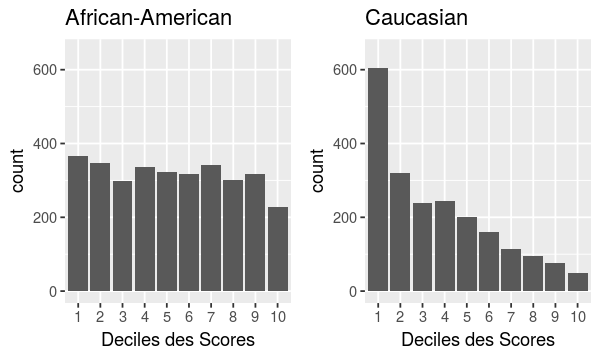

In [42]:
options(repr.plot.width=5, repr.plot.height=3)
pblack <- ggplot(data=filter(df_f, origEthn =="African-American"), aes(ordered(decile_score))) + 
          geom_bar() + xlab("Deciles des Scores") +
          ylim(0, 650) + ggtitle("African-American")
pwhite <- ggplot(data=filter(df, origEthn =="Caucasian"), aes(ordered(decile_score))) + 
          geom_bar() + xlab("Deciles des Scores") +
          ylim(0, 650) + ggtitle("Caucasian")
grid.arrange(pblack, pwhite,  ncol = 2)

Contrairement à ce qu'affirme la société *equivant* et pour cet exemple, les distributions des scores sont très différentes selon l'origine éthnique. Un test du $\chi 2$ élémentaire vérifie cette hypothèse. Cette disparité entre les distribution se retrouve évidemment dans l'estimation précédente de l'effet disproportionné.

In [43]:
chisq.test(table(df_f$decile_score,df_f$origEthn))


	Pearson's Chi-squared test

data:  table(df_f$decile_score, df_f$origEthn)
X-squared = 445.22, df = 9, p-value < 2.2e-16


### 5.2 Qualité prédictive du score COMPAS
L'objectif suivant est de comparer les capacités de prévision des modèles: celle issue du score COMPAS *vs.* celle fournie par un simple modèle de régression logistique. Bien d'autres algorithmes de prévision auraient pu être testés mais ce n'est pas le principal objectif.

#### Echantillon test
Pour rendre possible les comparaisons, les erreurs sont estimées sur le même échantillon test qui sera indépendant de l'échantillon d'apprentissage utilisé pour la régression logistique.

In [44]:
npop=nrow(df_t)
# tirage de 1000 indices sans remise
set.seed(11)
testi=sample(1:npop,1000)
#Liste des indices restant qui n’ont pas été tirés
appri=setdiff(1:npop,testi)
# Extraction échantillons d’apprentissage
dataApp=df_t[appri,]
# Echantillon test
dataTest=df_t[testi,]

#### Taux d'erreur du score COMPAS
Le seuil de score COMPAS de "4" est celui généralement retenu pour prévoir une récidive.

In [66]:
conf=table(dataTest$decile_score>4,dataTest$two_year_recid==1)
conf;tauxErr(conf)

       
        FALSE TRUE
  FALSE   355  167
  TRUE    169  309

[1] 33.6

Taux d'erreur très élevé comme attendu et légèrement différent de celui estimé sur toutes les données. Il dépend de l'chantillon qui a été tiré et donc de l'initialisation du génératoire de nombres aléatoires.

### 5.3 Qualité prédictive d'une régression logistique
Dans son étude, Problica propose l'estimation d'un modèle de régression logistique expliquant la variable `score_text` en fonction des variables: origine Ethnique, âge, *criminal history*, *future recidivism*, *charge degree*, genre, afin d'évaluer les influences de ces variables sur le score COMPAS. Propublica propose également de mettre en évidence l'effet des interactions avec la variable `age`. 

Plutôt que pour évaluer l'importance relative des facteurs ou de leurs interactions, la régression logistique est utilisée ci-dessous avec un objectif prédictif. La récidive peut elle être prédite en fonction des quelques caractéristiques connues des individus? Cette prévision est-elle meilleure ou tout du moins aussi mauvaise que celle fournie par le score COMPAS produit par la société *equivant*.
#### Estimation du modèle

In [46]:
model_logit <- glm(two_year_recid ~ sex+origEthn+age+age_cat+priors_count+
                   +c_charge_degree,family=binomial(link='logit'), data=dataApp)
summary(model_logit)


Call:
glm(formula = two_year_recid ~ sex + origEthn + age + age_cat + 
    priors_count + +c_charge_degree, family = binomial(link = "logit"), 
    data = dataApp)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-2.572  -1.002  -0.605   1.071   2.251  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)             0.57496    0.23313   2.466   0.0137 *  
sexMale                 0.38876    0.08593   4.524 6.06e-06 ***
origEthnCaucasian      -0.08420    0.07075  -1.190   0.2341    
age                    -0.04680    0.00676  -6.923 4.41e-12 ***
age_catGreater than 45  0.31976    0.16583   1.928   0.0538 .  
age_catLess than 25     0.26774    0.10537   2.541   0.0111 *  
priors_count            0.16831    0.00958  17.569  < 2e-16 ***
c_charge_degreeM       -0.16830    0.07106  -2.368   0.0179 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null devia

#### Taux d'erreur

In [47]:
pihat<-predict(model_logit,newdata=dataTest)
tauxErr(table(pihat>0.5,dataTest$two_year_recid))

[1] 35.7

*Remarques:*
- Limitation: ce modèle ne s'applique qu'à des détenus libérés ou libérables, pas à des individus jamais condamnés.
- Conditionnellement à la présence des autres variables, l'origine ethnique n'est pas significative dans le modèle.
- Le taux d'erreur de ce modèle élémentaire qui fait intervenir la gravité du crime précédent et le nombre d'incarcération est aussi mauvais que celui issu du score COMPAS. On retrouve bien le type de résultats de Dressel et Farid (2018).
- Une itération des estimations de ces erreurs par validation croisée *Monte Carlo* donnerait une inducation sur leur distribution. 

### Conclusion
Biaisé donc discriminatoire à bien des points de vue sur cet exemple de données et présentant une aussi mauvaise qualité prédictive qu'un modèle de régression logistique rudimentaire, le score COMPAS est à éviter.

### Références
